# Pymaceuticals Inc.
---

### Fast Links Here:

**The Section Below:** Just basic data prep. Merging data frames, cleaning out duplicate data we can't salvage, and ascertaining how many subjects we're working with.

**[Summary Stats](#sum_stats):** Basic descriptive statistics for each drug treatment group.

**[Bar and Pie Charts](#bar_stuff):** Practicing making charts with different libraries.

**[Quartiles, Outliers, and Boxplots](#box_stuff):** Practicing making somewhat dynamic charts using quartiles and boxplots.

**[Line and Scatter Plots](#plot_stuff):** Practicing other kinds of data visualization techniques.

**[Correlation and Linear Regression](#corr_stuff):** This is basically baby's first machine learning task. Thankfully, it's doable in a few lines with a few lines of code and a basic understanding of math.
 

In [1]:
# Import Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

# Read data into dataframes
mouse_df = pd.read_csv("data/Mouse_metadata.csv") # Contains data about each mouse and their physical/treatment descriptions
results_df = pd.read_csv("data/Study_results.csv") # Contains time-series data about tumor growth/decline with each mouse

# Combine the data into a single DataFrame by Mouse ID since that's the one column they share
rat_df = results_df.merge(mouse_df, how="outer", on="Mouse ID")
print(rat_df.shape) # Returns (rows, columns) of dataframe
rat_df.head(20) # These are here more for the people to know what to expect from this merge

(1893, 8)


,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22
5,b128,25,43.262145,1,Capomulin,Female,9,22
6,b128,30,40.605335,1,Capomulin,Female,9,22
7,b128,35,37.967644,1,Capomulin,Female,9,22
8,b128,40,38.379726,2,Capomulin,Female,9,22
9,b128,45,38.982878,2,Capomulin,Female,9,22


In [6]:
# Checking the number of unique mice.
len(rat_df["Mouse ID"].unique())

249

In [7]:
# Our data should be uniquely identified by Mouse ID and Timepoint

rat_df[rat_df.duplicated(subset=["Mouse ID", "Timepoint"])] # Subset kwarg here defines what columns are considered for duplicate identification

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
861,g989,0,45.000000,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


Unless we somehow have rat quantum superposition, each Mouse ID should only have one data point per point of recorded time. This returns the duplicate mice by duplicate Time and ID, meaning that there are somehow 2 different results for the same rat at the same time. 
> For example: There exists 2 measurements for subject g989 at timepoints 0, 5, 10, 15, and 20

As it's highly unlikely for rats to be recycled for something as permanent and life-altering as tumor treatments, this is probably a clerical error on the dataset's part

In [8]:
dups = rat_df[rat_df.duplicated(subset=["Mouse ID", "Timepoint"])]["Mouse ID"].unique() # Stapled ["Mouse Id"].unique() there to return every unique Mouse ID with bad duplicate data
dups # This is just here as a dynamic, referenceable data type so that duplicate row retrieval still works even with multiple matches

array(['g989'], dtype=object)

In [9]:
# Why we need Dups as an array, an example: Getting all the data that matches the mice with duplicate timepoints
rat_df[rat_df["Mouse ID"].isin(dups)]

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
860,g989,0,45.000000,0,Propriva,Female,21,26
861,g989,0,45.000000,0,Propriva,Female,21,26
862,g989,5,48.786801,0,Propriva,Female,21,26
863,g989,5,47.570392,0,Propriva,Female,21,26
864,g989,10,51.745156,0,Propriva,Female,21,26
865,g989,10,49.880528,0,Propriva,Female,21,26
866,g989,15,51.325852,1,Propriva,Female,21,26
867,g989,15,53.442020,0,Propriva,Female,21,26
868,g989,20,55.326122,1,Propriva,Female,21,26
869,g989,20,54.657650,1,Propriva,Female,21,26


Given that there are 2 different measurements for 4 of the 5 pairs of duplicate timepoint data, there are 16 different ways this mouse's Tumor Volume trajectory could've went. As we can't tell what really happened with this subject, this piece of data must unfortunately be declared void for the purposes of this exercise.

In [10]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
rat_df.drop(rat_df[rat_df["Mouse ID"].isin(dups)].index, inplace=True) 
# df.drop takes in row indexes, so I'm just getting the array of indexes from the dataframe generated in the previous cell
rat_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,b128,0,45.000000,0,Capomulin,Female,9,22
1,b128,5,45.651331,0,Capomulin,Female,9,22
2,b128,10,43.270852,0,Capomulin,Female,9,22
3,b128,15,43.784893,0,Capomulin,Female,9,22
4,b128,20,42.731552,0,Capomulin,Female,9,22
...,...,...,...,...,...,...,...,...
1888,m601,25,33.118756,1,Capomulin,Male,22,17
1889,m601,30,31.758275,1,Capomulin,Male,22,17
1890,m601,35,30.834357,1,Capomulin,Male,22,17
1891,m601,40,31.378045,1,Capomulin,Male,22,17


In [12]:
# Checking the number of mice in the clean DataFrame (Should be one less for this dataset)
# The assignment has asked for all rows matching the duplicate to be removed 
len(rat_df["Mouse ID"].unique())

248

<a id='sum_stats'></a>
## Summary Statistics

In [15]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Groupby is (usually) your friend
rat_group = rat_df.groupby(["Drug Regimen"]) # Apparently it's good practice to assign the groupby into a variable

# Aggregation and assembly here:
sum_df = rat_group["Tumor Volume (mm3)"].agg(["mean", "median", "var", "std", "sem", "count"])\
.rename(columns={"mean":"Mean Tumor Volume", 
                 "median":"Median Tumor Volume", 
                 "var":"Tumor Volume Sample Variance", 
                 "std":"Tumor Volume Sample Standard Deviation", 
                 "sem":"Tumor Volume Standard Error", 
                 "count":"Mice Timepoint Count"})
# Fortunately, each of these functions in the .agg method have been normalized to have one degree of freedom by default. If I needed to change any keyword arguments on anything, it seems that I'll have to manually do things line by line
# A Count column was added to help make sense of any variation in the Standard Error

sum_df

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Sample Variance,Tumor Volume Sample Standard Deviation,Tumor Volume Standard Error,Mice Timepoint Count
Drug Regimen,,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346,230
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821,178
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236,178
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860,188
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466,186
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331,181
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332,148
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955,228
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111,181


At a glance, it seems that Capomulin and Ramicane performed the best, but it's also important to note that this is the summary stats of *all* data. Each of these aggregation stats have been influenced by the 45 cubic millimeters of tumors that all rats start with and thus does not paint a representative picture of the tumor volume each rat has after the treatment.

In fact, this chart should've been filtered more as not every mouse lived or was recorded for the same amount of time. Mouse f932, for example, only had its starting time datapoint (maybe it died prematurely), so it should not have been considered for the aggregation. Mouse z435 also only went up to timepoint = 10 days. Perhaps we should've only accounted for the final results of those subjects that made it past the 30-day mark.

It's still interesting to note that both Capomulin and Ramicane seem to have more consistent data given their smaller variance and standard deviation. Their larger amount of data also shrinks their standard error and makes their results slightly more reliable to look at.

<a id='bar_stuff'></a>
## Bar and Pie Charts
If you're wondering about the duplicate charts here, the assignment asked us to create one with both Pandas' and Matplotlib's built-in functions. Call it practice for getting used to arbitrary syntax.

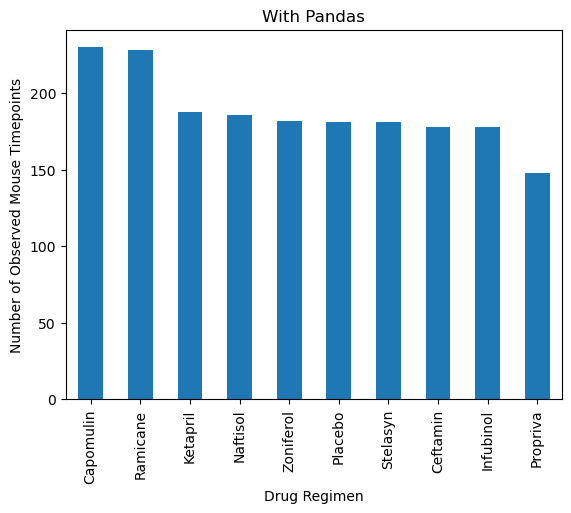

In [26]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.
count_df = sum_df.sort_values(by="Mice Timepoint Count", ascending=False) # Just recycling this dataframe from the previous cell
count_df.plot(kind="bar", use_index=True, y="Mice Timepoint Count", title="With Pandas", xlabel="Drug Regimen", ylabel="Number of Observed Mouse Timepoints", legend=None) #use_index is used here because the dataframe made by the groupby conveniently used the drug's names as indexes
plt.show()

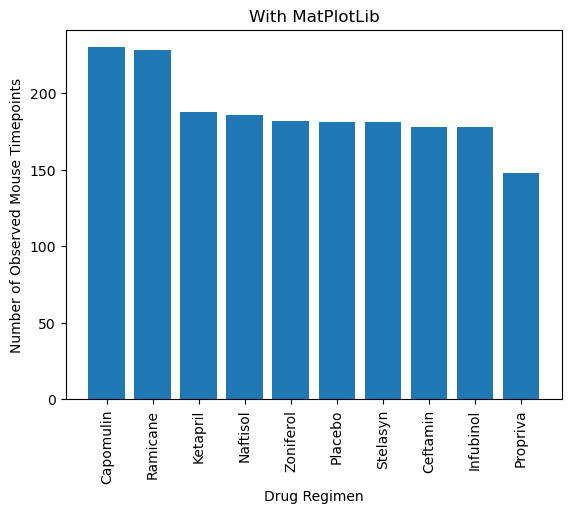

In [27]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.
plt.bar(count_df.index, count_df["Mice Timepoint Count"])
plt.xticks(rotation=90)

plt.xlabel("Drug Regimen")
plt.ylabel("Number of Observed Mouse Timepoints")
plt.title("With MatPlotLib")

plt.show()

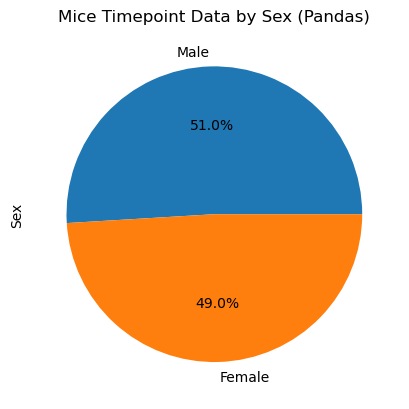

In [28]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas

rat_df["Sex"].value_counts().plot(kind = "pie", use_index=True, autopct="%1.1f%%", title="Mice Timepoint Data by Sex (Pandas)")
plt.show()

So, turns out, we're comparing the proportion of female vs male mice in terms of the number of time points they have. If we ran the pie chart simply by the distribution from the metadata, we'd get 125 male mice and 123 female mice (excluding that one duplicate rat) as seen in the next cell. However, by comparing the number of data points instead, we get 958 timepoints from the lads and 922 from the lasses, as shown by this slightly more divided pie chart above.

This could mean that more female mice died off during the duration of the experiment. Assuming each mouse is recorded an equal amount of times, the pie chart above about timepoints should share the same proportions as the chart below about mouse sex demographics. This could suggest that perhaps female mice have a higher mortality rate during these tumor treatment experiments.

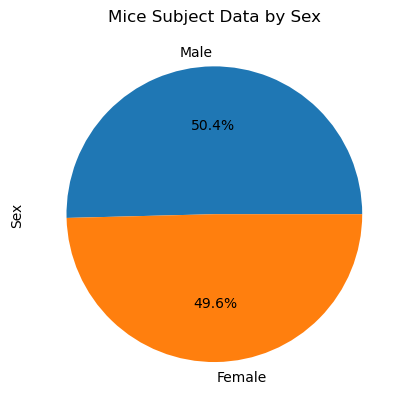

In [29]:
# Just as a comparison:
mouse_df.drop(mouse_df[mouse_df["Mouse ID"].isin(dups)].index, inplace=True)
plt.pie(mouse_df["Sex"].value_counts(), labels=["Male","Female"], autopct='%1.1f%%')
plt.title("Mice Subject Data by Sex")
plt.ylabel("Sex")
plt.show()

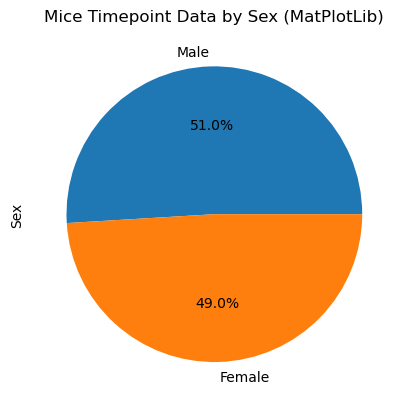

In [30]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
plt.pie(rat_df["Sex"].value_counts(), labels=["Male","Female"], autopct='%1.1f%%')
plt.title("Mice Timepoint Data by Sex (MatPlotLib)")
plt.ylabel("Sex")
plt.show()

<a id='box_stuff'></a>
## Quartiles, Outliers and Boxplots

In [36]:
# Goal: Calculate the final tumor volume of each mouse across four of the treatment regimens: 
treatments= ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"] # Will be useful later for plot labels and iteration
# You can edit the list here to get plots for the things you want to see

# Gets the last (greatest) timepoint for each mouse
# df.groupby([id])[timepoint] gives a series of timepoints for each group. Max obviously gets the max value of that
max_time_df = rat_df.groupby(["Mouse ID"])["Timepoint"].max().reset_index() # Added this reset_index at the end so it's easier to merge stuff later

# Merge this group df of each mouse's last recorded timepoint with the original DataFrame to get the tumor volume at the last timepoint
last_res_df = max_time_df.merge(rat_df, how="left", on=["Mouse ID", "Timepoint"]) # Left Join because I don't really need data from any other point in time
last_res_df

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age_months,Weight (g)
0,a203,45,67.973419,2,Infubinol,Female,20,23
1,a251,45,65.525743,1,Infubinol,Female,21,25
2,a262,45,70.717621,4,Placebo,Female,17,29
3,a275,45,62.999356,3,Ceftamin,Female,20,28
4,a366,30,63.440686,1,Stelasyn,Female,16,29
...,...,...,...,...,...,...,...,...
243,z435,10,48.710661,0,Propriva,Female,12,26
244,z578,45,30.638696,0,Ramicane,Male,11,16
245,z581,45,62.754451,3,Infubinol,Female,24,25
246,z795,45,65.741070,3,Naftisol,Female,13,29


In [42]:
# Instead of initializing an empty list to fill with tumor vol data for plotting, I opted to just use a groupby method to get what I need
# The groupby is constructed from the dataframe shown in the previous cell, so I can easily get aggregation data that way
max_tumor_group = last_res_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"]

# Calculate the IQR and quantitatively determine if there are any potential outliers
# If you call any of the dataframes below, you should see the iqr and outlier bounds for all treatment groups
iqr = max_tumor_group.quantile(0.75)-max_tumor_group.quantile(0.25)
lbound = max_tumor_group.quantile(0.25)-(1.5*iqr)
ubound = max_tumor_group.quantile(0.75)+(1.5*iqr)

# Mathematically extracting outliers just to prove that I know basic statistics
for i in treatments: # Refer to previous cell to see the "treatments" list we're iterating through
    test = max_tumor_group.get_group(i) # For each group that we want to reference:
    print(f"{i}'s potential outliers (ID/Value): {test[(test < lbound[i]) | (test > ubound[i])]}") # Select the slice we want based off of the bounds(+/-)1.5IQR rule
    # Accessing stuff in Pandas Series is weird. I'm glad this black magic somehow works

Capomulin's potential outliers (ID/Value): Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane's potential outliers (ID/Value): Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol's potential outliers (ID/Value): 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin's potential outliers (ID/Value): Series([], Name: Tumor Volume (mm3), dtype: float64)


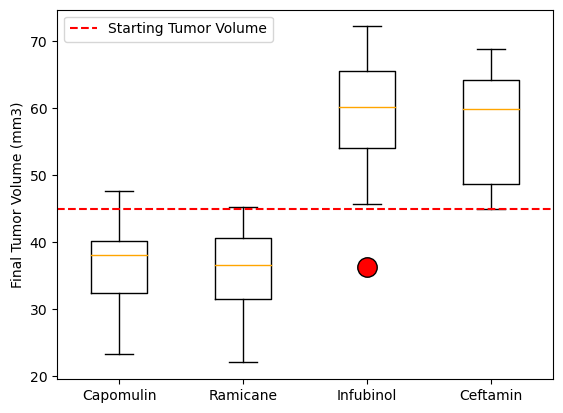

In [52]:
# Generate a box plot that shows the distrubution of the tumor volume for each treatment group.

# Turns out I can do this with a bunch of series. I also added a rename method so I don't have to go bald wondering about xticks
test = pd.concat([max_tumor_group.get_group(i).rename(i) for i in treatments], axis="columns")

# I'm very relieved to see that Pandas allows me to graph boxplots as if I'm making a bar chart. If you added extra items into the "treatments" list, you'll see the quantity of boxes reflected in the cell below
test.plot(kind="box", 
          capprops={"color":"black"}, 
          whiskerprops={"color":"black"}, 
          boxprops={"color":"black"}, 
          medianprops={"color":"orange"}, 
          flierprops={"markerfacecolor":"red", "markersize":"14"}, 
          ylabel="Final Tumor Volume (mm3)") # Unfortunately, it does seem that I have to manually assign everything if I want to change colors
plt.axhline(y=45, c="r", linestyle="--", label="Starting Tumor Volume") # Added a reference line to show where Tumor Volumes started
plt.legend()
plt.show()

Notably, with the red reference line, you can see that practically all subjects taking Infubinol and Ceftamin have worsened throughout the course of their trial period while Capomulin and Ramicane-using mice have generally recovered.

<a id='plot_stuff'></a>
## Line and Scatter Plots

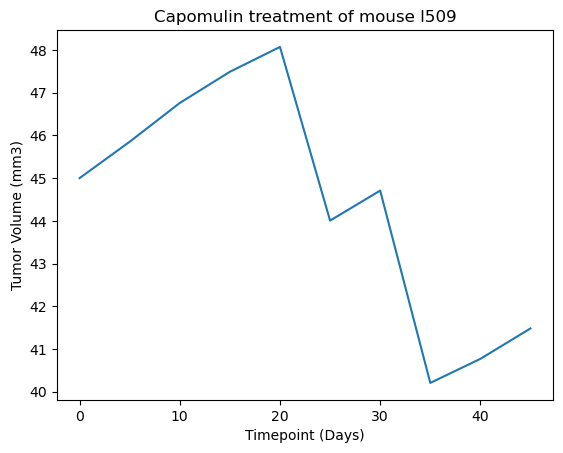

In [55]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin
# You can check out the trajectories for different mice by changing the Mouse ID below
rat_filt_df = rat_df[rat_df["Mouse ID"]=="l509"].reset_index(drop=True)

plt.plot(rat_filt_df["Timepoint"], rat_filt_df["Tumor Volume (mm3)"])
plt.title(f"{rat_filt_df.loc[0, 'Drug Regimen']} treatment of mouse {rat_filt_df.loc[0, 'Mouse ID']}")
plt.xlabel("Timepoint (Days)")
plt.ylabel("Tumor Volume (mm3)")
plt.show()

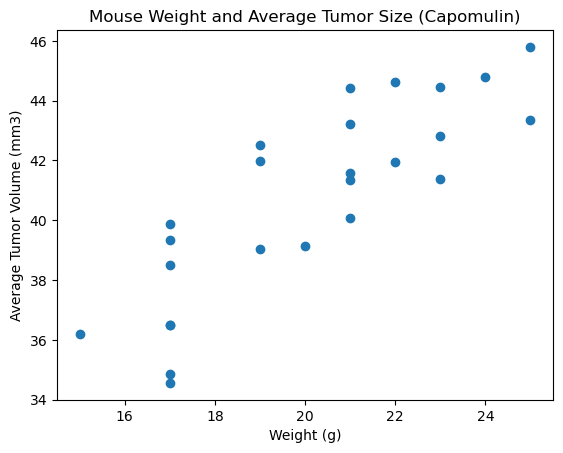

In [63]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen
# This chart belongs in the section below, but whatever. Change drug_name here to see distributions for other treatment groups
drug_name = "Capomulin"

drug_filt_df = rat_df[rat_df["Drug Regimen"]==drug_name].groupby("Mouse ID").mean(numeric_only=True)
plt.scatter(drug_filt_df["Weight (g)"], drug_filt_df["Tumor Volume (mm3)"])
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.title(f"Mouse Weight and Average Tumor Size ({drug_name})")
plt.show()

<a id='corr_stuff'></a>
## Correlation and Regression

The Pearson (R) correlation coefficient between mouse weight and average observed tumor volume here is 0.84


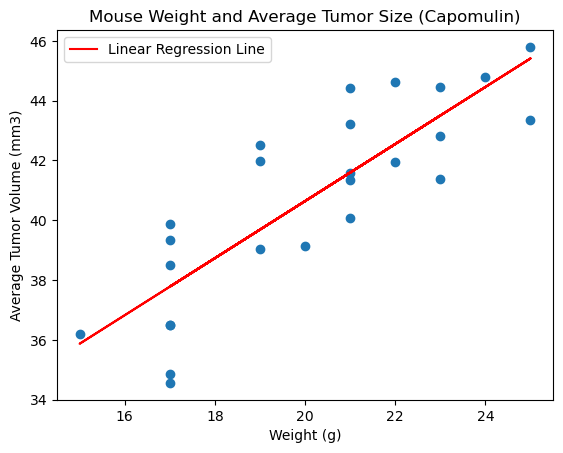

In [67]:
# Calculate the correlation coefficient and a linear regression model 
# for mouse weight and average observed tumor volume for the entire Capomulin regimen
corr = st.pearsonr(drug_filt_df["Weight (g)"], drug_filt_df["Tumor Volume (mm3)"]).statistic
# returns a (stat, p-value) pair, so I just got the first item

print(f"The Pearson (R) correlation coefficient between mouse weight and average observed tumor volume here is {corr:.2f}")

# This feels a lot nicer than scipy's linregress function, though apparently linregress is more performant?
fit = np.polyfit(drug_filt_df["Weight (g)"], drug_filt_df["Tumor Volume (mm3)"], deg=1) # Returns least squares best-fit coefficients and residuals. For a linear thing, this returns (slope, y-intercept)
reg = np.polyval(fit, drug_filt_df["Weight (g)"]) # Returns y values for you based on the regression from the previous line and some range of x that you provide

# What's funny here is that I could probably shove the code for fit and reg into the line below and still have it work, but I don't because I'm not a lunatic
plt.plot(drug_filt_df["Weight (g)"], reg, color="red", label="Linear Regression Line") # Plots the line based on the x values you have and the y-values plotted in the previous line

plt.scatter(drug_filt_df["Weight (g)"], drug_filt_df["Tumor Volume (mm3)"])
plt.legend()
plt.xlabel("Weight (g)")
plt.ylabel("Average Tumor Volume (mm3)")
plt.title(f"Mouse Weight and Average Tumor Size ({drug_name})")
plt.show()